# Computer and Robot Vision project (Teil 1: Die Lokalisierung)

In diesem Notebook geht es darum, wie wir Geschwindigkeitsschilder lokalisieren und klassifizieren können. Anders als üblich setzen wir dabei nicht auf herkömmliche Bildverarbeitung, sondern trainieren KI-Modelle, die diese Aufgaben eigenständig übernehmen können.

Die Idee dahinter ist, das Projekt in zwei Teile aufzuteilen, die unabhängig voneinander funktionieren können. Ein Modell wird speziell darauf trainiert, die Schilder im Bild zu lokalisieren, während ein separates Modell nur für die Klassifizierung zuständig ist. Dieses Notebook konzentriert sich auf die Lokalisierung und gibt Einblicke in die Methoden und Erkenntnisse, die dabei zum Einsatz kommen.

---

**Author:**

Dominik Bücher, Hochschuhle Heilbronn, Automotive System Engineering Master | dbuecher@stud.hs-heilbronn.de

Aaron Kiani, Hochschuhle Heilbronn, Mechatronik und Robotik Master | akiani@stud.hs-heilbronn.de


**Professor:**

Prof. Dr. Dieter Maier 

dieter.maier@hs-heilbronn.de

---

## Table of Contents

#### 1. [Einleitung](#Introduction)
#### 2. [Importieren der Bibliotheken](#Import)
#### 3. [Erstellen eines eigenen Datensatzes](#Dataset)
#### 4. [Training der Modelle](#modelle)
#### 5. [Evaluation](#Evaluation)
#### 6. [Testing](#Testing)
#### 7. [Diskussion der Ergebnisse](#Diskussion)

---

## 1. Einleitung <a id="Introduction"></a>

Im kommenden Kapitel wird zunächst die Struktur dieses Notebooks vorgestellt sowie das übergeordnete Ziel dieser Aufgabe erläutert.

Wie bereits zu Beginn des Notebooks erwähnt, liegt der Fokus dieses Abschnitts auf der Lokalisierung von Geschwindigkeitsschilder. Hierbei stehen verschiedene Ansätze zur Verfügung, wobei wir uns für einen eher klassischen Weg entschieden haben: die Verwendung von Cascading-Modellen.

Cascading-Modelle repräsentieren eine spezielle Klasse von Klassifikationsmodellen, die nicht nur auf dem etablierten "Haar-like features"-Ansatz basieren, sondern auch Local Binary Pattern (LBP) einbeziehen. Diese kombinierte Methode vereint die Effizienz der Haar-ähnlichen Merkmale mit der präzisen Texturerkennung von LBP, was eine vielseitige Lösung für die Objekterkennung in Bildern bietet. Der Begriff "cascading" (kaskadierend) leitet sich davon ab, dass diese Modelle hierarchisch angeordnete Kaskaden von Klassifikatoren nutzen.

Die Grundidee der Cascading-Modelle besteht darin, hierarchisch angeordnete Kaskaden von Klassifikatoren zu verwenden. Jede Stufe dieser Kaskade filtert gezielt bestimmte Bildbereiche und leitet nur die vielversprechendsten Regionen an die nachfolgende Stufe weiter. Diese kaskadierende Struktur ermöglicht eine effiziente Ablehnung von irrelevanten Bereichen und konzentriert die Ressourcen auf vielversprechende Regionen, was insbesondere bei der Verarbeitung großer Bildmengen von Vorteil ist.

Obwohl Cascading-Modelle ihre Bekanntheit hauptsächlich der Gesichtserkennung verdanken, eignen sie sich ebenso für die Erkennung anderer Objekte wie Geschwindigkeitsschilder oder Fahrzeuge. Der Trainingsprozess umfasst die Nutzung positiver und negativer Beispiele, um das Modell auf die spezifischen Mustererkennungsaufgaben anzupassen. Diese adaptive Anpassung ermöglicht eine präzise und effiziente Objekterkennung in verschiedenen Kontexten.

---

## 2. Importieren der Bibliotheken <a id="Import"></a>

In [2]:
import os
import shutil
import cv2
import numpy as np
import tensorflow as tf
import time
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
import csv
import random

---
## 3. Erstellen eines eigenen Datensatzes <a id="Dataset"></a>

Um ein Cascading-Modell erfolgreich zu trainieren, ist ein geeigneter Datensatz von entscheidender Bedeutung. Zu diesem Zweck wurden verschiedene Videos in und um Heilbronn aufgenommen. Die Aufnahmen erfolgten mit einer GoPro 11 unter den folgenden Einstellungen: 30 FPS (Bildern pro Sekunde) und einer Auflösung von 1920x1080 Pixel (HD).

Die aufgenommenen Videos wurden anschließend mithilfe eines speziellen Skripts in Bilddateien umgewandelt.

In [ ]:
def video_to_frames(video_path, output_path):
    video_capture = cv2.VideoCapture(video_path)
    
    if not video_capture.isOpened():
        print("Fehler beim Öffnen des Videos.")
        return
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    frame_count = 0
    
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        
        frame_filename = f"frame_{frame_count:04d}.jpg"
        frame_path = os.path.join(output_path, frame_filename)
        cv2.imwrite(frame_path, frame)
        frame_count += 1
    print(f"{frame_count} Frames wurden erfolgreich extrahiert.")
    video_capture.release()


video_path = r"videos_24_11_2023\video_speed_combined.mp4"
output_path = r"videos_24_11_2023\combined"
video_to_frames(video_path, output_path)

Nach der Umwandlung der Videos in Bilder ist es nun möglich, die einzelnen Bilder zu labeln, was von entscheidender Bedeutung ist, da ein Modell ohne diese Annotationen nicht trainiert werden kann.

Der Kennzeichnungsprozess beinhaltete das Auffinden aller Geschwindigkeitsschilder in einem Bild und das Hinzufügen von Begrenzungsrahmen (Bounding Boxes) um diese. Es gibt verschiedene Programme, die für diese Aufgabe verwendet werden können, und wir haben uns für DarkLabel 2.4 entschieden. Dabei ist zu erwähnen das das Labeln sehr viel zeit in anspruch nehmen kann, wobei DarkLabel2.4 diese zeit zumindest etwas verkürzt hat. 

Nachdem alle Bilder erfolgreich gelabelt wurden, wird eine Textdatei generiert, die die Daten zu jeder einzelnen Bounding Box enthält. Diese Datei bildet die Grundlage für das spätere Training des Modells.

Die Text Datei ist dabei wie folgt aufgebaut: 00000.jpg,1,795,428,50,49. Jedoch wird für das training ein Format wie dieses "00000.jpg 1 795 428 50 49" benötigt, bzw "frame_3321.jpg 2 177 499 157 141 1692 577 103 93" falls es zwei Bounding Boxen in einem Bild gibt. Zusätzlich dazu dürfen die Koordinaten nicht die Größe des Bildes überschreiten. All diese kleinen Änderungen werden in den nachfolgenden Funktionen behoben.

In [ ]:
def adjust_coordinates(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            parts = line.strip().split(' ')
            if len(parts) == 6:
                x_coordinate = int(parts[2])
                width = int(parts[4])

                # Überprüfe, ob die Koordinaten größer als 1919 sind
                if x_coordinate > 1919 or (x_coordinate + width) > 1919:
                    if x_coordinate > 1919:
                        x_coordinate = 1919 - width
                    if (x_coordinate + width) > 1919:
                        width = 1919 - x_coordinate

                # Überprüfe, ob die Koordinaten kleiner als 1 sind
                if x_coordinate < 1 or (x_coordinate + width) < 1:
                    if x_coordinate < 1:
                        x_coordinate = 1
                    if (x_coordinate + width) < 1:
                        width = 1 - x_coordinate

                # Erstelle die aktualisierte Zeile
                updated_line = f"{parts[0]},{parts[1]},{x_coordinate},{parts[3]},{width},{parts[5]}\n"
                outfile.write(updated_line)
            else:
                # Schreibe Zeilen ohne das erwartete Format unverändert
                outfile.write(line)


def combine_lines(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        lines = infile.readlines()
        i = 0
        while i < len(lines) - 1:
            current_line = lines[i].strip().split(';')
            next_line = lines[i + 1].strip().split(';')

            if current_line[0] == next_line[0]:
                combined_line = [current_line[0], str(int(current_line[1]) + 1)] + [current_line[2]] + current_line[3:] + next_line[1:]
                lines[i] = ' '.join(combined_line) + '\n'
                lines.pop(i + 1)
            else:
                i += 1

        # Ersetze alle Kommas durch Leerzeichen in den verbleibenden Zeilen
        for j in range(len(lines)):
            lines[j] = lines[j].replace(';', ' ')

        outfile.writelines(lines)



adjust_coordinates(r'Dominik\annotation_files\train.txt', r'Dominik\annotation_files\train2.txt')
combine_lines(r'Dominik\gt copy2.txt', r'Dominik\pos_new.txt')

Nachdem die Textdatei nun im korrekten Format vorliegt, schreiten wir zum nächsten Schritt: der Aufteilung des Datensatzes in Trainings- und Testbilder. Der folgende Code generiert zwei neue Textdateien für diese Aufteilung. Dabei werden die Daten zunächst zufällig durchmischt und anschließend aufgeteilt. Der Trainingsdatensatz umfasst dabei 95% der Bilder, während der Testdatensatz nur 5% enthält. Obwohl eine übliche Aufteilung 90 zu 10 wäre, haben wir uns aufgrund der begrenzten Anzahl von insgesamt 3726 Bildern entschieden, dem Training einen größeren Datensatzanteil zuzuweisen, wie in der folgenden Abbildung verdeutlicht wird:

<img src="Notebook_Bilder/Split_data.png" width="500" height="400">


In [ ]:
def split_dataset(input_datei, ausgabe_datei_1, ausgabe_datei_2, trennungsprozentsatz=5):
    with open(input_datei, 'r') as datei:
        zeilen = datei.readlines()
    
    random.shuffle(zeilen)
    
    trennungspunkt = int(len(zeilen) * (trennungsprozentsatz / 100))
    ausgabe_1 = zeilen[:trennungspunkt]
    ausgabe_2 = zeilen[trennungspunkt:]
    
    with open(ausgabe_datei_1, 'w') as datei_1:
        datei_1.writelines(ausgabe_1)
    
    with open(ausgabe_datei_2, 'w') as datei_2:
        datei_2.writelines(ausgabe_2)


input_datei = r'Dominik\annotation_files\pos_own.txt'
ausgabe_datei_1 = r'Dominik\annotation_files\test.txt'
ausgabe_datei_2 = r'Dominik\annotation_files\train.txt'
split_dataset(input_datei, ausgabe_datei_1, ausgabe_datei_2, trennungsprozentsatz=5)

Nachdem die beiden Textdateien erstellt wurden, haben Sie die Möglichkeit, die Bilder in die entsprechenden Ordner zu verschieben. Obwohl dies nicht zwingend erforderlich ist, trägt es zur besseren Übersicht bei. Für das eigentliche Training muss die Textdatei der Trainingsdaten zwar erneut verarbeitet werden, doch dieser Schritt wird in einem späteren Kapitel ausführlich behandelt.

---

## 4. Training der Modelle <a id="modelle"></a>

Wie schon zuvor erwähnt werden für die Lokalisierung Cascaden Modelle verwendet. OpenCV stellt hierfür ein Programm zu verfügung um diese zu trainieren. Bei dem Training mit OpenCV ist es möglich zwischen zwei verschiedenen Cascaden Modellen zu wählen, dem "Haar-like features"-Ansatz oder dem Local Binary Pattern (LBP)-Ansatz. Diese beiden Varianten werden im folgenden kurz erläutert.

**Haar Cascade:**     
Haar Cascades sind eine Methode der Gesichts- und Objekterkennung, die auf der Analyse von Haar-ähnlichen Mustern basiert. Diese Modelle nutzen eine Kaskadenstruktur von Merkmalsklassifikatoren, wobei einfache Merkmale in den frühen Stadien für schnelle Ablehnungen verwendet werden und komplexere Merkmale in späteren Stadien für genauere Überprüfungen. Ein Nachteil von Haar Cascades kann ihre Empfindlichkeit gegenüber Variationen in Pose, Beleuchtung und Hintergrundbedingungen sein.

**LBP Cascade:**   
Local Binary Pattern (LBP) ist eine Methode zur Texturbeschreibung in Bildern. Sie erfasst lokale Muster, indem sie jeden Pixel mit seinen Nachbarn vergleicht und binäre Codes für lokale Muster erzeugt. LBP wird häufig in Gesichts- und Objekterkennungssystemen eingesetzt. Ein Nachteil von LBP besteht in seiner begrenzten Unterscheidungskraft, insbesondere in Szenarien mit geringem Kontrast oder komplexen Texturen. Trotzdem ist LBP eine effektive Methode zur Extraktion von Texturmerkmalen.

Um die Modelle nun trainineren zu können muss zunächst die opencv_traincascade.exe von OpenCV heruntergeladen werden. Mit diesem Programm ist es möglich die Modelle in der Kommandozeile zu trainieren. Wie ein solcher Befehlsaufruf aussehen könnte ist folgend dargestellt:

C:/Users/Dominik/Documents/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data Dominik/models/cascade_12/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 10 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP

Um zuverstehen wie sich dieser Befehl zusammensetz werden die Parameter kurz vorgestellt.
1. Zunächst wird mit einem Pfad die ausführbare Datei von OpenCV verlinkt.
2. -data gibt an wo das fertige Modell abegseichert werden soll.
3. -vec gibt an wo sich die .vec Datei der Labels befindet. Diese wird mit der opencv_createsamples.exe und der zuvor konstruierten Text Datei erstellt.
4. -bg gibt den Pfad zu der Text Datei an in der sich die Speicherorte für die Negativen Beispiele an.
5. -precalcValBufSize und -precalcIdxBufSize reserviert Speicher für die Ausführung um so schneller arbeiten zu können. 
6. -w 24 -h 24 legt fest wie groß die kleinsten zu erkennenden Features in einem Bild sind, hier sind es 24 mal 24 Pixel.
7. -numPos und -numNeg legen fest wieviel Positive Daten und wieviele Negative Daten für das Training verwendet werden.
8. -numStages gibt die Anzahl an Epochen für das Training an.
9. -maxFalseAlarmRate dieser Wert gibt an wie hoch der Prozentsatz für False-Psoitive Werte sein darf.
10. -minHitRate gibt die minimale gewünschte Trefferquote für jede Stufe des Klassifikators an.
11. -featureType wählt zum Schluss aus ob das Haar oder LBP Verfahren verwendet werden soll.

In [1]:
import os
def erstelle_ordner(weg):
    # Überprüfen, ob der Ordner existiert
    if not os.path.exists(weg):
        # Ordner erstellen, wenn er nicht existiert
        os.makedirs(weg)
        print(f"Der Ordner '{weg}' wurde erstellt.")
    else:
        print(f"Der Ordner '{weg}' existiert bereits.")

erstelle_ordner("localization_models/")

Der Ordner 'localization_models/' existiert bereits.


#### Training für 5 Epochen:

**maxFalseAlarmRate = 0.1:**

In [22]:
# Haar: (206m 40.7s)
erstelle_ordner("localization_models/HAAR_1750_01_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_1750_01_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 5 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_3500_01_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_3500_01_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 5 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_7000_01_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_7000_01_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 5 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

Der Ordner 'localization_models/HAAR_1750_01_5/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/HAAR_1750_01_5/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 5
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.1
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 500
mode: BASIC
Number of unique features given windowSize [24,24] : 162336

Stages 0-4 are loaded
Der Ordner 'localization_models/HAAR_3500_01_5/' ex

In [23]:
# LBP: (2m 0.0s)
erstelle_ordner("localization_models/LBP_1750_01_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_1750_01_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 5 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_3500_01_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_3500_01_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 5 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_7000_01_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_7000_01_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 5 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

Der Ordner 'localization_models/LBP_1750_01_5/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/LBP_1750_01_5/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 5
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: LBP
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.1
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
Number of unique features given windowSize [24,24] : 8464

Stages 0-4 are loaded
Der Ordner 'localization_models/LBP_3500_01_5/' existiert bereits.
-

**maxFalseAlarmRate = 0.05:**

In [24]:
# Haar: (274 57.0s)
erstelle_ordner("localization_models/HAAR_1750_005_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_1750_005_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 5 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_3500_005_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_3500_005_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 5 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_7000_005_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_7000_005_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 5 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

Der Ordner 'localization_models/HAAR_1750_005_5/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/HAAR_1750_005_5/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 5
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.05
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 500
mode: BASIC
Number of unique features given windowSize [24,24] : 162336

Stages 0-4 are loaded
Der Ordner 'localization_models/HAAR_3500_005_5/

In [25]:
# LBP: (6m 20.2s)
erstelle_ordner("localization_models/LBP_1750_005_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_1750_005_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 5 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_3500_005_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_3500_005_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 5 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_7000_005_5/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_7000_005_5/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 5 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

Der Ordner 'localization_models/LBP_1750_005_5/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/LBP_1750_005_5/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 5
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: LBP
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.05
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
Number of unique features given windowSize [24,24] : 8464

Stages 0-4 are loaded
Der Ordner 'localization_models/LBP_3500_005_5/' existiert bereit

#### Training für 7 Epochen:

**maxFalseAlarmRate = 0.1:**

In [26]:
# Haar: (233m 35.4s)
erstelle_ordner("localization_models/HAAR_1750_01_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_1750_01_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 7 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_3500_01_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_3500_01_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 7 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_7000_01_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_7000_01_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 7 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

Der Ordner 'localization_models/HAAR_1750_01_7/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/HAAR_1750_01_7/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 7
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.1
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 500
mode: BASIC
Number of unique features given windowSize [24,24] : 162336

Stages 0-6 are loaded
Der Ordner 'localization_models/HAAR_3500_01_7/' ex

In [27]:
# LBP: (46m 44.6s)
erstelle_ordner("localization_models/LBP_1750_01_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_1750_01_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 7 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_3500_01_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_3500_01_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 7 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_7000_01_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_7000_01_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 7 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

Der Ordner 'localization_models/LBP_1750_01_7/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/LBP_1750_01_7/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 7
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: LBP
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.1
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
Number of unique features given windowSize [24,24] : 8464

Stages 0-6 are loaded
Der Ordner 'localization_models/LBP_3500_01_7/' existiert bereits.
-

**maxFalseAlarmRate = 0.05:**

In [28]:
# Haar:
erstelle_ordner("localization_models/HAAR_1750_005_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_1750_005_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 7 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_3500_005_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_3500_005_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 7 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_7000_005_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_7000_005_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 7 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

Der Ordner 'localization_models/HAAR_1750_005_7/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/HAAR_1750_005_7/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 7
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.05
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 500
mode: BASIC
Number of unique features given windowSize [24,24] : 162336

Stages 0-6 are loaded
Der Ordner 'localization_models/HAAR_3500_005_7/

In [29]:
# LBP:
erstelle_ordner("localization_models/LBP_1750_005_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_1750_005_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 7 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_3500_005_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_3500_005_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 7 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_7000_005_7/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_7000_005_7/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 7 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

Der Ordner 'localization_models/LBP_1750_005_7/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/LBP_1750_005_7/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 7
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: LBP
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.05
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
Number of unique features given windowSize [24,24] : 8464

Stages 0-6 are loaded
Der Ordner 'localization_models/LBP_3500_005_7/' existiert bereit

#### Training für 10 Epochen:

**maxFalseAlarmRate = 0.1:**

In [31]:
# Haar:
erstelle_ordner("localization_models/HAAR_1750_01_10/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_1750_01_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 10 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_3500_01_10/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_3500_01_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 10 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_7000_01_10/")
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_7000_01_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 10 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

Der Ordner 'localization_models/HAAR_1750_01_10/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/HAAR_1750_01_10/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 10
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.1
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 500
mode: BASIC
Number of unique features given windowSize [24,24] : 162336

Stages 0-9 are loaded
Der Ordner 'localization_models/HAAR_3500_01_10/

In [3]:
# LBP:
erstelle_ordner("localization_models/LBP_1750_01_10/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_1750_01_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 10 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_3500_01_10/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_3500_01_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 10 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_7000_01_10/")
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_7000_01_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 10 -maxFalseAlarmRate 0.1 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

Der Ordner 'localization_models/LBP_1750_01_10/' existiert bereits.
---------------------------------------------------------------------------------
Training parameters are pre-loaded from the parameter file in data folder!
Please empty this folder if you want to use a NEW set of training parameters.
---------------------------------------------------------------------------------
PARAMETERS:
cascadeDirName: localization_models/LBP_1750_01_10/
vecFileName: dataset/positive_samples/train/train.vec
bgFileName: dataset/negative_samples/neg2.txt
numPos: 3500
numNeg: 1750
numStages: 10
precalcValBufSize[Mb] : 12000
precalcIdxBufSize[Mb] : 12000
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: LBP
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.999
maxFalseAlarmRate: 0.1
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
Number of unique features given windowSize [24,24] : 8464

Stages 0-9 are loaded
Der Ordner 'localization_models/LBP_3500_01_10/' existiert bereit

**maxFalseAlarmRate = 0.05:**

Die Haar Modelle mit einer maxFalseAlarmRate von 0.05 wurden für 10 Epochen NICHT Trainiert. Das liegt daran, dass die Modelle für 7 Epochen teilweise schon einen ganzen Tag für das Training gebraucht haben. Für 10 Epochen würde das Training deutlich zulange gehen, weshalb wir uns entschieden haben diese nicht mehr zu Trainieren. Der code um das Training ausführen zu können wurde der vollständigkeithalber dennoch in dem Notebook gelassen.

In [ ]:
# Haar:
erstelle_ordner("localization_models/HAAR_1750_005_10/")
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_1750_005_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 10 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_3500_005_10/")
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_3500_005_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 10 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

erstelle_ordner("localization_models/HAAR_7000_005_10/")
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/HAAR_7000_005_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 10 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType HAAR -maxWeakCount 500

In [ ]:
# LBP:
erstelle_ordner("localization_models/LBP_1750_005_10/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_1750_005_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 1750 -numStages 10 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_3500_005_10/") ###
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_3500_005_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 3500 -numStages 10 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

erstelle_ordner("localization_models/LBP_7000_005_10/")
!C:/Users/domin/Documents/opencv_old/opencv/build/x64/vc15/bin/opencv_traincascade.exe -data localization_models/LBP_7000_005_10/ -vec dataset/positive_samples/train/train.vec -bg dataset/negative_samples/neg2.txt -precalcValBufSize 12000 -precalcIdxBufSize 12000 -w 24 -h 24 -numPos 3500 -numNeg 7000 -numStages 10 -maxFalseAlarmRate 0.05 -minHitRate 0.999 -featureType LBP -maxWeakCount 500

---

## 5. Evaluation <a id="Evaluation"></a>

In [24]:
import	cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

def calculate_intersection(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    x_intersection = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    y_intersection = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    return x_intersection * y_intersection


def calculate_union(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    area_bbox1 = w1 * h1
    area_bbox2 = w2 * h2
    intersection = calculate_intersection(bbox1, bbox2)
    union = area_bbox1 + area_bbox2 - intersection
    return union


def process_images_from_file(cascade_name, cascade, output_folder, ground_truth_file):
    with open(ground_truth_file, 'r') as gt_file:
        gt_lines = gt_file.readlines()

    true_positives = 0
    false_positives = 0
    actual_positives = 0

    for line in gt_lines:
        values = line.strip().split(' ')
        image_name = values[0]
        num_bounding_boxes = int(values[1])
        bbox_values = list(map(int, values[2:]))
        actual_positives += num_bounding_boxes
        image_path = os.path.join('dataset/positive_samples/test/', image_name)
        image = cv2.imread(image_path)

        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Erkenne Geschwindigkeitsschilder
        speed_signs = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(24, 24))
        # Extrahiere tatsächliche Bounding-Boxen
        bboxes_gt = [bbox_values[i:i+4] for i in range(0, len(bbox_values), 4)]

        # Vergleiche mit Ground Truth
        for bbox_gt in bboxes_gt:
            closest_sign = None
            min_distance = float('inf')

            for (cx, cy, w, h) in speed_signs:
                distance = abs(cx - bbox_gt[0])
                if distance < min_distance:
                    min_distance = distance
                    closest_sign = (cx, cy, w, h)

            if closest_sign is not None:
                cx, cy, w, h = closest_sign
                intersection = calculate_intersection([cx, cy, w, h], bbox_gt)
                union = calculate_union([cx, cy, w, h], bbox_gt)
                iou = intersection / union

                if iou > 0.5:  # Schwellenwert für eine korrekte Erkennung
                    true_positives += 1
                    # Zeichne die Bounding-Box auf das Bild
                    cv2.rectangle(image, (cx - (w//2), cy - (h//2)), (cx + (w//2), cy + (h//2)), (0, 255, 0), 2)
                else:
                    false_positives += 1


                # Speichere das Bild mit Bounding-Box im output_folder
        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, image)

    false_negative = actual_positives - true_positives
    true_negative = 0
    # Print additional metrics (Precision, Recall, etc.)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    print(f'Precision: {precision}, Recall: {recall}')

    conf_matrix = np.array([[true_positives, false_positives],
                       [false_negative, true_negative]])

    # Plot Confusion Matrix
    labels = ['Positive', 'Negative']
    categories = ['True Positive', 'False Positive', 'False Negative', 'True Negative']

    sns.heatmap(conf_matrix, annot=np.array([[f'TP: {true_positives}', f'FP: {false_positives}'], [f'FN: {false_negative}', 'TN: Not available']]),
                fmt='', cmap="Blues", xticklabels=labels, yticklabels=labels, annot_kws={'size': 14})

    output_path_matrix1 = os.path.join(output_folder, cascade_name)
    output_path_matrix2 = f"localization_models/{cascade_name}/{cascade_name}"
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Number of ground truth data: {actual_positives})(Precision: {round(precision, 3)}, Recall: {round(recall, 3)})')
    plt.savefig(output_path_matrix1 + '.png', bbox_inches='tight', pad_inches=0.1, facecolor='w')
    plt.savefig(output_path_matrix2 + '.png', bbox_inches='tight', pad_inches=0.1, facecolor='w')
    plt.show()

    return precision, recall



def lade_cascade_aus_ordner(ordnerpfad):
    cascade_dict = {}

    for root, dirs, files in os.walk(ordnerpfad):
        for datei in files:
            if datei == "cascade.xml":
                cascade_name = os.path.basename(root)  # Name des übergeordneten Ordners als Schlüssel
                cascade_pfad = os.path.join(root, datei)

                # Lade die Cascade-Klassifikator-Datei
                cascade = cv2.CascadeClassifier(cascade_pfad)

                # Speichere die Cascade in einem Dictionary mit dem Namen als Schlüssel
                cascade_dict[cascade_name] = cascade

    return cascade_dict


def erstelle_plot(ergebnisse):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Erstelle einen DataFrame aus der Ergebnisliste
    df = pd.DataFrame(ergebnisse)

    # Erstelle einen Punktplot für Precision und Recall
    plt.figure(figsize=(20, 12))  # Größe des Plots erhöht
    scatterplot = sns.scatterplot(data=df, x='Precision', y='Recall', hue='Modell', s=100)

    # Füge die Namen der Modelle als Textpunkte hinzu mit mehr Abstand
    for i, row in df.iterrows():
        scatterplot.annotate(row['Modell'], (row['Precision'], row['Recall']), fontsize=8, ha='left', va='bottom')

    plt.title('Vergleich der Modelle')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

    

if __name__ == "__main__":
    
    cascade_speedsign = cv2.CascadeClassifier('localization_models/LBP_3500_005_7/cascade.xml')
    if cascade_speedsign.empty():
        print("Error: Unable to load cascade classifier.")
    
    erstelle_ordner("results/")
    output_folder_path = 'results/'
    ground_truth_file = r"Dominik\annotation_files\test.txt"

    # precision, recall = process_images_from_file(cascade_speedsign, output_folder_path, ground_truth_file)


    # Liste für die Ergebnisse
    ergebnisse = []

    # Beispielaufruf mit dem Pfad zum Hauptordner
    ordnerpfad = "localization_models"
    cascades = lade_cascade_aus_ordner(ordnerpfad)

    # Beispiel: Zugriff auf eine bestimmte Cascade
    gewuenschte_cascade_name = "LBP_3500_005_7"
    gewuenschte_cascade = cascades.get(gewuenschte_cascade_name)

    if gewuenschte_cascade is not None:
        print(f"Cascade '{gewuenschte_cascade_name}' wurde erfolgreich geladen.")
    else:
        print(f"Cascade '{gewuenschte_cascade_name}' nicht gefunden.")

    # Schleife durch jedes geladene Modell
    for cascade_name, cascade in cascades.items():
        print(f"Verarbeite Modell: {cascade_name}")
        precision, recall = process_images_from_file(cascade_name, cascade, output_folder_path, ground_truth_file)
        print(f"Precision für {cascade_name}: {precision}, Recall: {recall}")


        # Speichere Ergebnisse in der Liste
        ergebnisse.append({'Modell': cascade_name, 'Precision': precision, 'Recall': recall})
        print("-" * 50)
    # Speichern der Liste in einer Datei
    with open('localization_models/liste.json', 'w') as datei:
        json.dump(ergebnisse, datei)

    # Laden der Liste aus der Datei
    with open('localization_models/liste.json', 'r') as datei:
        geladene_liste = json.load(datei)
    erstelle_plot(geladene_liste)

Der Ordner 'results/' existiert bereits.
Cascade 'LBP_3500_005_7' wurde erfolgreich geladen.
Verarbeite Modell: HAAR_1750_005_5


KeyboardInterrupt: 

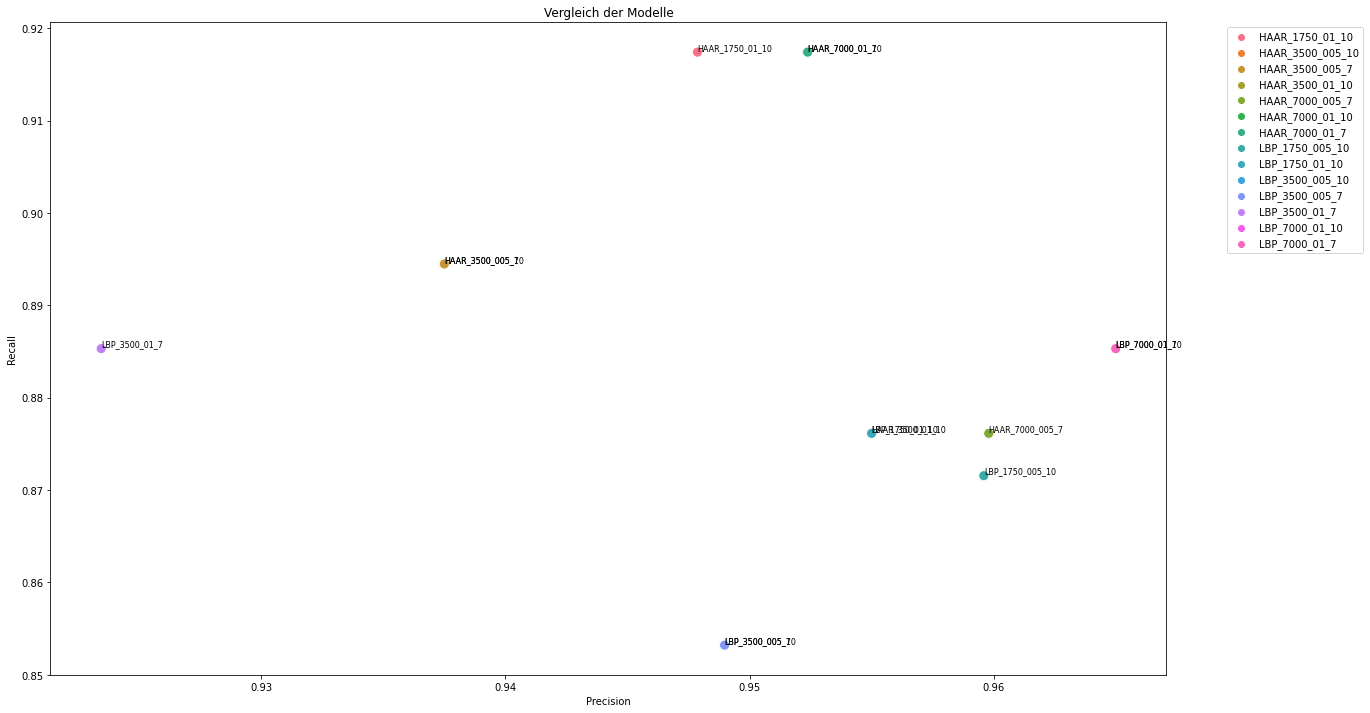

In [31]:
def erstelle_plot(ergebnisse):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Erstelle einen DataFrame aus der Ergebnisliste
    df = pd.DataFrame(ergebnisse)

    # Erstelle einen Punktplot für Precision und Recall

    # Filtere die Daten für Modelle mit Precision und Recall über 0.85
    hochperformante_modelle = df[(df['Precision'] > 0.92) & (df['Recall'] > 0.85)]
    plt.figure(figsize=(20, 12))  # Größe des Plots erhöht
    scatterplot = sns.scatterplot(data=hochperformante_modelle, x='Precision', y='Recall', hue='Modell', s=100)

    # Füge die Namen der Modelle als Textpunkte hinzu mit mehr Abstand
    for i, row in hochperformante_modelle.iterrows():
        scatterplot.annotate(row['Modell'], (row['Precision'], row['Recall']), fontsize=8, ha='left', va='bottom')

    plt.title('Vergleich der Modelle')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

with open('localization_models/liste.json', 'r') as datei:
    geladene_liste = json.load(datei)
erstelle_plot(geladene_liste)

---

## 6. Testing <a id="Testing"></a>

Nach dem nun alle Modelle trainiert wurden und die Precision und der Recall für jedes Modell berechnet wurde, kann entschiedenen werden welches der Modelle das beste ist.

Im Nachfolgenden werden die beiden besten Modelle nochmals etwas genauer betrachtet.

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt


def lade_bilder_aus_ordner(ordner_pfad):
    bilder = []
    dateiformate = ['png', 'jpg', 'jpeg', 'gif']  # Unterstützte Dateiformate

    for datei in os.listdir(ordner_pfad):
        if datei.lower().split('.')[-1] in dateiformate:
            bild_pfad = os.path.join(ordner_pfad, datei)
            bilder.append(bild_pfad)

    return bilder

def zeige_bilder(bilder):
    anzahl_bilder = len(bilder)
    reihen = (anzahl_bilder + 2) // 3  # Berechne die Anzahl der Zeilen

    fig, axs = plt.subplots(reihen, 3, figsize=(10, 5 * reihen))

    for i in range(reihen):
        for j in range(3):
            index = i * 3 + j
            if index < anzahl_bilder:
                bild = Image.open(bilder[index])
                axs[i, j].imshow(bild)
                axs[i, j].axis('off')

    plt.show()


def show_results(cascade_path):  
    cascade_speedsign = cv2.CascadeClassifier(cascade_path)
    if cascade_speedsign.empty():
        print("Error: Unable to load cascade classifier.")

    erstelle_ordner("results/")
    output_folder_path = 'results/'
    ground_truth_file = r"Dominik\annotation_files\test.txt"

    precision, recall = process_images_from_file(cascade_speedsign, output_folder_path, ground_truth_file)


    ordner_pfad = "Pfad/zum/deinem/Ordner"  # Ersetze durch den Pfad zu deinem Ordner
    bilder = lade_bilder_aus_ordner(ordner_pfad)

    if bilder:
        zeige_bilder(bilder)
    else:
        print("Keine unterstützten Bilder im angegebenen Ordner gefunden.")

In [ ]:
cascade_path = r"localization_models\LBP_7000_005_7\cascade.xml"
show_results(cascade_path)

In [ ]:
cascade_path = r"localization_models\LBP_7000_005_7\cascade.xml"
show_results(cascade_path)

In [ ]:
def test_speed(cascade):

    image_path = r'dataset\positive_samples\test\frame_2303.jpg'
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    start_time = time.time()
    objects = cascade.detectMultiScale(gray_image, scaleFactor=1.4, minNeighbors=5, minSize=(24, 24))
    end_time = time.time()

    print("Time for the localization: {:.4f} Seconds".format(end_time - start_time))

    for (x, y, w, h) in objects:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow('Detected Objects', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


if __name__ == "__main__":
    cascade_speedsign = cv2.CascadeClassifier('localization_models/HAAR_1750_01_5/cascade.xml')
    test_speed(cascade_speedsign)

---

## 7. Diskussion der Ergebnisse <a id="Diskussion"></a>